#### Turnpike Property finite dimentional using Gekko library.

More information about Gekko : https://gekko.readthedocs.io/en/latest/CV_options.html 

Some examples of Gekko library: https://nbviewer.jupyter.org/url/apmonitor.com/wiki/uploads/Main/gekko.ipynb 

 #### Problem settings

Consider the following control systems

$$\begin{cases}x_{t}(t)+Ax(t)= Bu(t)\quad t\in (0,T),\\ x(0)=(1,1),\end{cases}$$
where $T=200$, and the matrices $A,B$ are given by
$$ A=\begin{pmatrix}1&1 \\-1&0\end{pmatrix},\quad B=\begin{pmatrix}0 \\1\end{pmatrix} .$$
Let's consider the matrices
$$C=\begin{pmatrix}0&1 \\1&0\end{pmatrix},\quad z=\begin{pmatrix}1 \\1.5\end{pmatrix},$$ 
and the optimal control problem
$$\min_{u\in L^{2}(0,T;Y)}\lbrace J^{T}(u)=\frac{1}{2}\biggr(\int_{0}^{T}\Vert u\Vert^{2}_{Y}+\Vert Cx-z\Vert^{2}_{X}dt\biggr):\quad x \text{ solution of the above system}\rbrace $$

Finally, consider the stationary problem 

$$\min_{u\in Y}\lbrace J^{s}(u)=\frac{1}{2}\biggr(\Vert u\Vert^{2}_{Y}+\Vert Cx-z\Vert^{2}_{X}\biggr):\quad x \text{ solution of }Ax=Bu\rbrace $$
where $X=\mathbb{R}^{n}$ and $Y=\mathbb{R}^{m}$. The following code solve both optimization problems and show the Turnpike Property.


In [101]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#We define a generic function to solve the optimizations problems

def dif_norm_evolu_vs_esta(A,B,C,Z,ti,tf,nt):

#Define the matrix values
    a11=A[0,0]  ; a12=A[0,1]
    a21=A[1,0]  ; a22=A[1,1]
    
    
    b1=B[0,0]
    b2=B[1,0]

    z1=Z[0,0]
    z2=Z[1,0]

    c11=C[0,0]  ; c12=C[0,1]
    c21=C[1,0]  ; c22=C[1,1]  
  

    ################################ Evolutive Problem #####################################
    m = GEKKO() # initialize gekko
    nt = 101    # Numero  de particiones
    m.time = np.linspace(ti,tf,nt) 
    
    
    # Variables
    x1 = m.Var(value=1)
    x2 = m.Var(value=1)
    
    x3 = m.Var(value=0)#Via esta variable minimizaremos el funcional objetivo
    
    u = m.Var(value=0)
    p = np.zeros(nt) # mark final time point
    p[-1] = 1.0
    final = m.Param(value=p)
    
    
    # Equations
   
    m.Equation(x1.dt()+a11*x1+a12*x2==b1*u)
    m.Equation(x2.dt()+a21*x1+a22*x2==b2*u)
    
    #Objetive Functional
    m.Equation(x3.dt()==0.5*(u**2)+0.5*(((x1*c11+x2*c12)-z1)**2+((c21*x1+x2*c22)-z2)**2))
    
    m.Obj(x3*final) # Objective function
    m.options.IMODE = 6 # optimal control mode
    m.solve(disp=False) # solve

    #Save the variables
    vector_x1=x1.value
    vector_x2=x2.value
    vector_u=u.value
    tiempo=m.time


    ################################### Stationary Problem #####################################
    m = GEKKO() # Initialize gekko
    # Use IPOPT solver (default)
    m.options.SOLVER = 3
    # Change to parallel linear solver
    #m.solver_options = ['linear_solver ma97']
    
    # Initialize variables
    xl1 = m.Var(value=1)
    xl2 = m.Var(value=1)

    ul = m.Var(value=0)
    
    # Equations
    m.Equation(a11*xl1+a12*xl2==b1*ul)
    m.Equation(a21*xl1+a22*xl2==b2*ul)
    
    m.Obj(0.5*(ul**2)+0.5*(((xl1*c11+xl2*c12)-z1)**2+((c21*xl1+xl2*c22)-z2)**2)) # Objective
    
    m.options.IMODE = 3 # Steady state optimization
    m.solve(disp=False) # Solve

    #Create constant vectors, with the outputs values
  
    vector_xl1= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl1.value
    vector_xl2= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*xl2.value
    vector_ul= (np.linspace(0.1,2,nt)/np.linspace(0.1,2,nt))*ul.value

    #We calculate the norm of the differences between the states and controls, evolutionary and stationary
    dif_x=((vector_xl1-vector_x1)**2+(vector_xl2-vector_x2)**2)**(1/2)
    dif_u=((vector_ul-vector_u)**2)**(1/2)

    return [dif_x,vector_x1,vector_x2,vector_xl1,vector_xl2,tiempo,dif_u,vector_ul,vector_u]    
    
    
#We define the matrices of the example
A=np.matrix(' 1  1  ;  -1  0 ')
B=np.matrix('0  ;  1  ')
Z= np.matrix('1  ;  1.5')
C=np.matrix(' 0  1  ;  1  0 ')

#We define the inicial and final time, and the time steps
ti=0
tf=200
nn=101


#Run the function 
[dif_x,vector_x1,vector_x2,vector_xl1,vector_xl2,tiempo,dif_u,vector_ul,vector_u]=dif_norm_evolu_vs_esta(A,B,C,Z,ti,tf,nn)
    

Text(0, 0.5, 'Values')

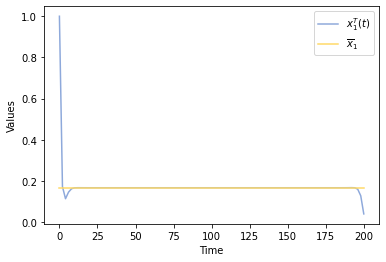

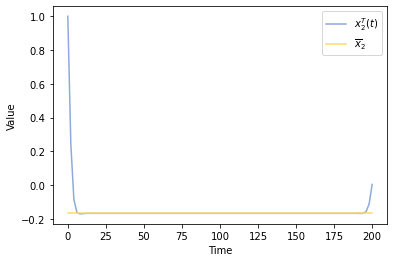

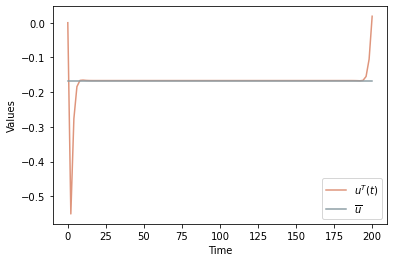

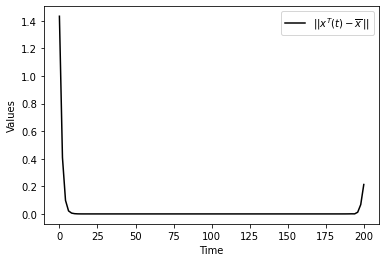

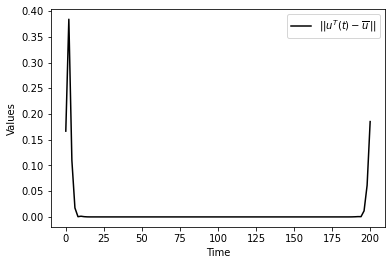

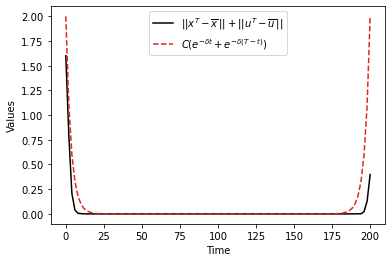

In [100]:
#Show the property!    
plt.figure(0) # plot results
plt.plot(tiempo,vector_x1,color='#8ea9db',label=r'$x_{1}^T(t)$')
plt.plot(tiempo,vector_xl1,color='#ffd966',label=r'$\overline{x}_{1}$')
plt.legend(loc='best')
plt.xlabel('Time')
#ax=plt.gca()
#ax.get_yaxis().set_visible(False)
#plt.xticks([])
plt.ylabel('Values')



    
plt.figure(1) # plot results
plt.plot(tiempo,vector_x2,color='#8ea9db',label=r'$x^T_2(t)$')
plt.plot(tiempo,vector_xl2,color='#ffd966',label=r'$\overline{x}_2$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Values')      



plt.figure(2) # plot results
plt.plot(tiempo,vector_u,color='#DF957C',label=r'$u^T(t)$')
plt.plot(tiempo,vector_ul,color='#8D9EA5',label=r'$\overline{u}$')
plt.legend(loc='best')
plt.xlabel('Time')
#ax=plt.gca()
#ax.get_yaxis().set_visible(False)
#plt.xticks([])
plt.ylabel('Values')

plt.figure(3) # plot results
plt.plot(tiempo,dif_x,'k-',label=r'$|| x^{T}(t)-\overline{x}\,||$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Values')

plt.figure(4) # plot results
plt.plot(tiempo,dif_u,'k-',label=r'$|| u^{T}(t)-\overline{u}\,||$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Values')


def f(t):
    delta=0.3
    C=2
    return (np.exp(-delta*t)+np.exp(-delta*(200-t)))*C

suma_dif=dif_u+dif_x

#plt.figure(5) # plot results
#plt.plot(tiempo,suma_dif,'k-',label=r'$|| x^{T}-\overline{x}\,|| +|| u^{T}-\overline{u}\,||$')
#plt.legend(loc='upper center')
#plt.xlabel('Time')
#plt.ylim(0,1.5) 
#plt.ylabel('Values')
#plt.savefig('Turnpike_exam_norm_1.png')

plt.figure(6) # plot results
plt.plot(tiempo,suma_dif,'k-',label=r'$|| x^{T}-\overline{x}\, || +|| u^{T}-\overline{u}\,||$')
plt.plot(tiempo, f(tiempo),'y--',color='#E62121', label='$C(e^{-\delta t}+e^{-\delta (T-t)})$' )
plt.legend(loc='upper center')
plt.xlabel('Time')
#plt.ylim(0,1.5) 
plt.ylabel('Values')
#plt.savefig('Turnpike_exam_norm_2.png')

 Creado por Martin Hernandez Salinas.